# Outlier detection with Autoencoders on MNIST dataset


Goal: Use autoencoder to detect outliers.

Regular - "0"  
Outlier - "6"

Hypothesis:
Model will have a high reconstruction loss on "6" when trained on "0".


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import time

In [2]:
# Load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# combine dataset
combined_images = np.concatenate((X_train, X_test), axis=0)
combined_labels = np.concatenate((y_train, y_test), axis=0)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Regular & Outlier images


In [3]:
regular_images = combined_images[combined_labels == 0]  # zero images
regular_labels = np.zeros(len(regular_images), dtype=int)  # zero label = 0

six_images = combined_images[combined_labels == 6]  # outlier images

sample_size = 500
idx = np.random.choice(len(six_images), sample_size, replace=False)

outlier_images = six_images[idx]
outlier_labels = np.ones(len(outlier_images), dtype=int)  # outlier label = 1

### Train test split


In [4]:
synthetic_images = np.concatenate((regular_images, outlier_images), axis=0)
synthetic_labels = np.concatenate((regular_labels, outlier_labels), axis=0)

In [5]:
train_images, test_images, train_labels, test_labels = (
    sk.model_selection.train_test_split(
        synthetic_images,
        synthetic_labels,
        test_size=0.1,
        stratify=synthetic_labels,
        shuffle=True,
    )
)

In [ ]:
# we will train the model on only zero images only
train_images_regular = train_images[train_labels == 0]
train_labels_regular = np.zeros(train_images_regular.shape[0], dtype=int)

In [7]:
test_images_regular = test_images[test_labels == 0]  # for zeros
test_images_outlier = test_images[test_labels == 1]  # for outliers

In [8]:
# Normalize images
normalize_img = lambda img: img / 255.0

train_images_regular_norm = normalize_img(train_images_regular)
test_images_regular_norm = normalize_img(test_images_regular)
test_images_outlier_norm = normalize_img(test_images_outlier)

In [9]:
len(train_images_regular)

6212

In [10]:
len(train_images)

6662

In [11]:
train_images.shape

(6662, 28, 28)

## First autoencoder - Dense


In [12]:
train_images.shape[1]

28

In [13]:
coding_size_dense = 28

# Encoder
inp1 = tf.keras.layers.Input(shape=(train_images.shape[1], train_images.shape[2], 1))
a = tf.keras.layers.Flatten()(inp1)
a = tf.keras.layers.Dense(128, activation="relu")(a)
a = tf.keras.layers.Dense(128, activation="relu")(a)
a = tf.keras.layers.Dense(coding_size_dense, activation="relu")(a)

# Decoder
b = tf.keras.layers.Dense(128, activation="relu")(a)
b = tf.keras.layers.Dense(128, activation="relu")(b)
out1 = tf.keras.layers.Dense(
    train_images.shape[1] * train_images.shape[2], activation="sigmoid"
)(b)
out1 = tf.keras.layers.Reshape((train_images.shape[1], train_images.shape[2], 1))(out1)


dense_autoencoder = tf.keras.Model(inp1, out1)

dense_autoencoder.compile(optimizer="adam", loss="mse")

dense_autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 28)                  │           3,612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           3,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,964 (945.17 KB)

 Trainable params: 241,964 (945.17 KB)

 Non-trainable params: 0 (0.00 B)

### Training


In [14]:
# Use train_images_regular as both input and target for the autoencoder
start_time = time.time()

history = dense_autoencoder.fit(
    train_images_regular_norm,
    train_images_regular_norm,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.1222 - val_loss: 0.0455
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0410 - val_loss: 0.0338
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308 - val_loss: 0.0280
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0259 - val_loss: 0.0235
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0216 - val_loss: 0.0196
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0183 - val_loss: 0.0179
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 10/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0147
Epoch 11/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 12/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0129 - val_l

### MSE Function


In [15]:
# MSE
calc_mse = lambda true, pred: np.mean(
    (true.reshape(true.shape[0], -1) - pred.reshape(pred.shape[0], -1)) ** 2, axis=1
)

### Reconstrution loss


In [16]:
reconstruction_loss_dense_outlier = dense_autoencoder.predict(test_images_outlier_norm)
reconstruction_loss_dense_regular = dense_autoencoder.predict(test_images_regular_norm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [17]:
mse_regular = calc_mse(test_images_regular_norm, reconstruction_loss_dense_regular)
mse_outlier = calc_mse(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"MSE Regular:\n {mse_regular[:mse_outlier.shape[0]]}")
print("Min:", mse_regular.min())
print("Max:", mse_regular.max())
print()
print(f"MSE Outlier:\n {mse_outlier}")
print("Min:", mse_outlier.min())
print("Max:", mse_outlier.max())

MSE Regular:
 [0.00666588 0.00638108 0.01316592 0.00445198 0.00537286 0.00559752
 0.00667789 0.00463725 0.00316048 0.00575714 0.01274931 0.01163638
 0.00537077 0.00393157 0.01003733 0.01564061 0.00777576 0.00698912
 0.00390511 0.00958388 0.00951113 0.00471329 0.01642559 0.00661261
 0.00660788 0.03467731 0.00683604 0.00498088 0.00515644 0.00690707
 0.00591832 0.01256086 0.00960577 0.007993   0.00796637 0.00412017
 0.007363   0.01052391 0.00608301 0.00615936 0.00800918 0.01979808
 0.00841854 0.00393635 0.00733461 0.00845871 0.00882494 0.00579852
 0.01552768 0.01054765]
Min: 0.0027523563474786852
Max: 0.03660931102110106

MSE Outlier:
 [0.0303404  0.03682378 0.03653005 0.02844242 0.03354886 0.03151712
 0.03414931 0.03330202 0.02478399 0.01807687 0.02676762 0.04993978
 0.01973752 0.01866852 0.02813476 0.0476599  0.02512834 0.03234838
 0.03416884 0.03464638 0.01815547 0.02555796 0.04126771 0.02821856
 0.02998053 0.02907273 0.02031744 0.0395325  0.01940922 0.03206366
 0.04077331 0.01844536 0

In [18]:
mse_outlier.shape

(50,)

In [19]:
np.argmin(mse_outlier)

np.int64(42)

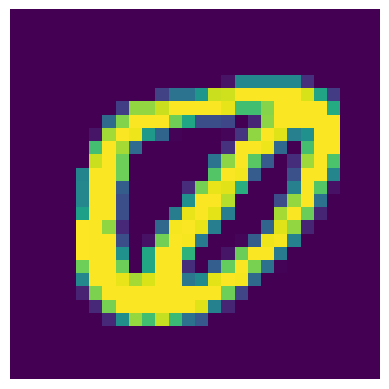

In [20]:
plt.imshow(test_images_regular_norm[np.argmax(mse_regular)])
plt.axis(False)
plt.show()

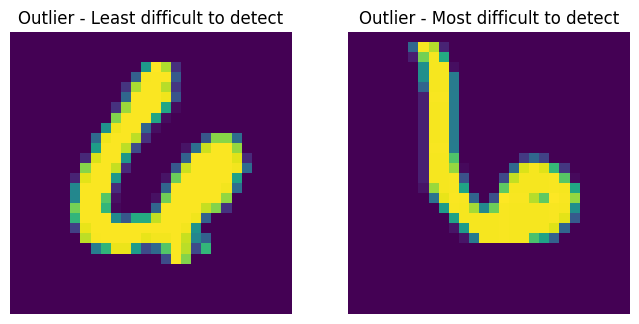

In [21]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_images_outlier_norm[np.argmin(mse_outlier)])
plt.axis(False)
plt.title("Outlier - Least difficult to detect")
plt.subplot(122)
plt.imshow(test_images_outlier_norm[np.argmax(mse_outlier)])
plt.axis(False)
plt.title("Outlier - Most difficult to detect")
plt.show()

### SSIM - structural similarity index measure [Higher is better]


In [22]:
def calc_ssim(true, pred, max_val=1.0):
    true = tf.cast(true, tf.float32)
    pred = tf.cast(pred, tf.float32)

    if len(true.shape) == 3:
        true = tf.expand_dims(true, -1)
    if len(pred.shape) == 3:
        pred = tf.expand_dims(pred, -1)

    if true.shape[3] > 1 and true.shape[1] == 1:
        true = tf.transpose(true, [0, 2, 3, 1])
    if pred.shape[3] > 1 and pred.shape[1] == 1:
        pred = tf.transpose(pred, [0, 2, 3, 1])

    ssim = []
    for i in range(true.shape[0]):
        ssim_score = tf.image.ssim(
            true[i : i + 1],
            pred[i : i + 1],
            max_val,  # maximum value for normalized images
        )
        ssim.append(ssim_score[0])

    return np.array(ssim)

In [23]:
ssim_regular = calc_ssim(test_images_regular_norm, reconstruction_loss_dense_regular)
ssim_outlier = calc_ssim(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"SSIM Regular:\n {ssim_regular[:ssim_outlier.shape[0]]}")
print("Min:", ssim_regular.min())
print("Max:", ssim_regular.max())
print()
print(f"SSIM Outlier:\n {ssim_outlier}")
print("Min:", ssim_outlier.min())
print("Max:", ssim_outlier.max())

SSIM Regular:
 [0.9486784  0.920395   0.8679238  0.96758527 0.94441956 0.9552486
 0.93213505 0.9528528  0.9637776  0.94831085 0.87381196 0.88031286
 0.9553182  0.9654356  0.9042527  0.8766898  0.9438489  0.9313066
 0.9613122  0.903293   0.8980642  0.9590693  0.7716266  0.9371106
 0.8879989  0.67441106 0.9303652  0.96162176 0.96029943 0.9362689
 0.94440866 0.8972655  0.8933937  0.9055195  0.93996465 0.9671107
 0.9234559  0.9220115  0.9489624  0.94499284 0.9177298  0.73545736
 0.9276639  0.96325225 0.9420048  0.9368451  0.9216617  0.9430511
 0.87862813 0.9060234 ]
Min: 0.33272922
Max: 0.9767329

SSIM Outlier:
 [0.63664633 0.5832034  0.55494136 0.69699913 0.60458916 0.62553513
 0.62960184 0.51363647 0.67772037 0.69325453 0.7041239  0.42658126
 0.68658465 0.67722857 0.6642823  0.5966258  0.6646463  0.6209545
 0.4816837  0.45598683 0.7645092  0.64562917 0.50666255 0.6723342
 0.6161786  0.7076832  0.7029557  0.3871243  0.61052155 0.4944652
 0.49418306 0.53572696 0.58245254 0.47003618 0.58810

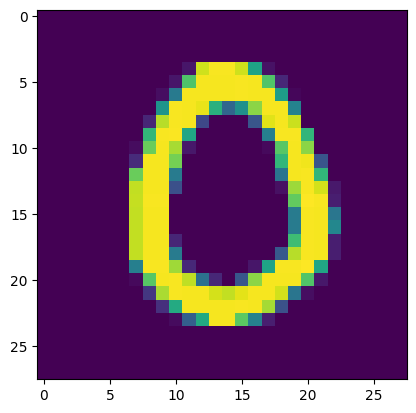

In [24]:
plt.imshow(test_images_regular_norm[np.argmax(ssim_regular)])
plt.show()

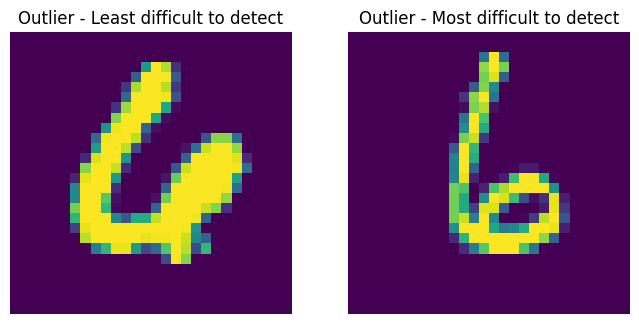

In [25]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_images_outlier_norm[np.argmax(ssim_outlier)])
plt.title("Outlier - Least difficult to detect")
plt.axis(False)
plt.subplot(122)
plt.imshow(test_images_outlier_norm[np.argmin(ssim_outlier)])
plt.title("Outlier - Most difficult to detect")
plt.axis(False)
plt.show()

- It is noticed that because the MLP learns by hardcoding the approximate pixel locations of the digits, small changes in training affects the mse (max and min values) and ssim values resulting in inconsistencies in which digits it struggles to identify.
- Also, it is clear when using SSIM that MLP is able to satisfactorily reconstruct images with very high SSIM >0.9 for most of the regular test images. Because "6" (outlier) and "0" (regular) are arguably similar looking, the SSIM score are not too bad >0.6 in most cases for "6"'s (outlier) but still distinguishable from the regular.


## Second Autoencoder - CNN


In [26]:
# Encoder
inp2 = tf.keras.layers.Input(shape=(train_images.shape[1], train_images.shape[2], 1))
x = tf.keras.layers.Rescaling(1 / 255.0)(inp2)
x = tf.keras.layers.Conv2D(14, (3, 3), strides=2, padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(7, (3, 3), strides=2, padding="same", activation="relu")(x)
# x = tf.keras.layers.Conv2D(7, (3, 3), strides=2, padding="same", activation="relu")(x)

# Decoder
y = tf.keras.layers.Conv2DTranspose(
    7, (3, 3), strides=2, padding="same", activation="relu"
)(x)
# y = tf.keras.layers.Conv2DTranspose(
#     7, (3, 3), strides=2, padding="same", activation="relu"
# )(y)
y = tf.keras.layers.Conv2DTranspose(
    14, (3, 3), strides=2, padding="same", activation="relu"
)(y)
out2 = tf.keras.layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(y)


conv_autoencoder = tf.keras.Model(inp2, out2)

conv_autoencoder.compile(optimizer="adam", loss="mse")

conv_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 14)          │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 7)             │             889 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 7)           │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 14)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             127 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,500 (9.77 KB)

 Trainable params: 2,500 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

### Training


In [28]:
start_time = time.time()

history = conv_autoencoder.fit(
    train_images_regular_norm,
    train_images_regular_norm,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 10/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 11/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 12/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_l

In this model, we can observe that, the autoencoder is not learning as the validation loss is stuck at 1503 and the "true" loss is hovering around 0.1510-0.1490 over the 40 epochs.


### Reconstruction Loss


In [29]:
reconstruction_loss_conv_outlier = conv_autoencoder.predict(test_images_outlier_norm)
reconstruction_loss_conv_regular = conv_autoencoder.predict(test_images_regular_norm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


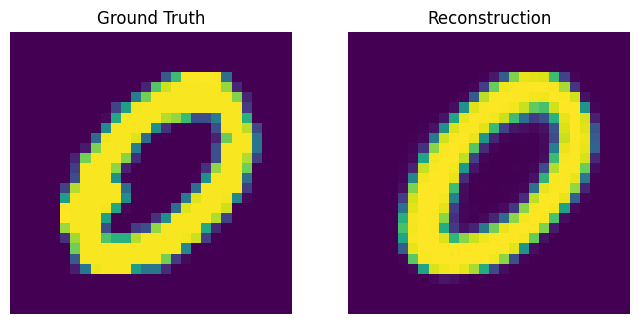

In [30]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_images_regular_norm[0])
plt.title("Ground Truth")
plt.axis(False)
plt.subplot(122)
plt.imshow(reconstruction_loss_dense_regular[0])
plt.title("Reconstruction")
plt.axis(False)
plt.show()

In [31]:
mse_regular = calc_mse(test_images_regular_norm, reconstruction_loss_dense_regular)
mse_outlier = calc_mse(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"MSE Regular:\n {mse_regular[:mse_outlier.shape[0]]}")
print("Min:", mse_regular.min())
print("Max:", mse_regular.max())
print()
print(f"MSE Outlier:\n {mse_outlier}")
print("Min:", mse_outlier.min())
print("Max:", mse_outlier.max())

MSE Regular:
 [0.00666588 0.00638108 0.01316592 0.00445198 0.00537286 0.00559752
 0.00667789 0.00463725 0.00316048 0.00575714 0.01274931 0.01163638
 0.00537077 0.00393157 0.01003733 0.01564061 0.00777576 0.00698912
 0.00390511 0.00958388 0.00951113 0.00471329 0.01642559 0.00661261
 0.00660788 0.03467731 0.00683604 0.00498088 0.00515644 0.00690707
 0.00591832 0.01256086 0.00960577 0.007993   0.00796637 0.00412017
 0.007363   0.01052391 0.00608301 0.00615936 0.00800918 0.01979808
 0.00841854 0.00393635 0.00733461 0.00845871 0.00882494 0.00579852
 0.01552768 0.01054765]
Min: 0.0027523563474786852
Max: 0.03660931102110106

MSE Outlier:
 [0.0303404  0.03682378 0.03653005 0.02844242 0.03354886 0.03151712
 0.03414931 0.03330202 0.02478399 0.01807687 0.02676762 0.04993978
 0.01973752 0.01866852 0.02813476 0.0476599  0.02512834 0.03234838
 0.03416884 0.03464638 0.01815547 0.02555796 0.04126771 0.02821856
 0.02998053 0.02907273 0.02031744 0.0395325  0.01940922 0.03206366
 0.04077331 0.01844536 0

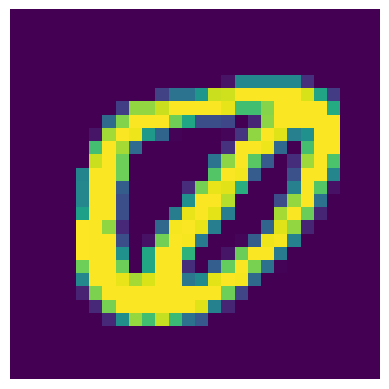

In [32]:
plt.imshow(test_images_regular_norm[np.argmax(mse_regular)])
plt.axis(False)
plt.show()

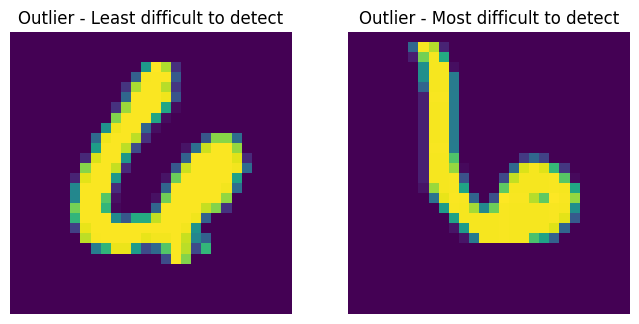

In [33]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_images_outlier_norm[np.argmin(mse_outlier)])
plt.title("Outlier - Least difficult to detect")
plt.axis(False)
plt.subplot(122)
plt.imshow(test_images_outlier_norm[np.argmax(mse_outlier)])
plt.title("Outlier - Most difficult to detect")
plt.axis(False)
plt.show()

### SSIM - structural similarity index measure [Higher is better]


In [34]:
ssim_regular = calc_ssim(test_images_regular_norm, reconstruction_loss_dense_regular)
ssim_outlier = calc_ssim(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"SSIM Regular:\n {ssim_regular[:ssim_outlier.shape[0]]}")
print("Min:", ssim_regular.min())
print("Max:", ssim_regular.max())
print()
print(f"SSIM Outlier:\n {ssim_outlier}")
print("Min:", ssim_outlier.min())
print("Max:", ssim_outlier.max())

SSIM Regular:
 [0.9486784  0.920395   0.8679238  0.96758527 0.94441956 0.9552486
 0.93213505 0.9528528  0.9637776  0.94831085 0.87381196 0.88031286
 0.9553182  0.9654356  0.9042527  0.8766898  0.9438489  0.9313066
 0.9613122  0.903293   0.8980642  0.9590693  0.7716266  0.9371106
 0.8879989  0.67441106 0.9303652  0.96162176 0.96029943 0.9362689
 0.94440866 0.8972655  0.8933937  0.9055195  0.93996465 0.9671107
 0.9234559  0.9220115  0.9489624  0.94499284 0.9177298  0.73545736
 0.9276639  0.96325225 0.9420048  0.9368451  0.9216617  0.9430511
 0.87862813 0.9060234 ]
Min: 0.33272922
Max: 0.9767329

SSIM Outlier:
 [0.63664633 0.5832034  0.55494136 0.69699913 0.60458916 0.62553513
 0.62960184 0.51363647 0.67772037 0.69325453 0.7041239  0.42658126
 0.68658465 0.67722857 0.6642823  0.5966258  0.6646463  0.6209545
 0.4816837  0.45598683 0.7645092  0.64562917 0.50666255 0.6723342
 0.6161786  0.7076832  0.7029557  0.3871243  0.61052155 0.4944652
 0.49418306 0.53572696 0.58245254 0.47003618 0.58810

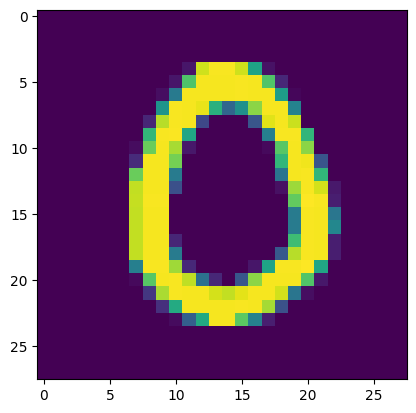

In [35]:
plt.imshow(test_images_regular_norm[np.argmax(ssim_regular)])
plt.show()

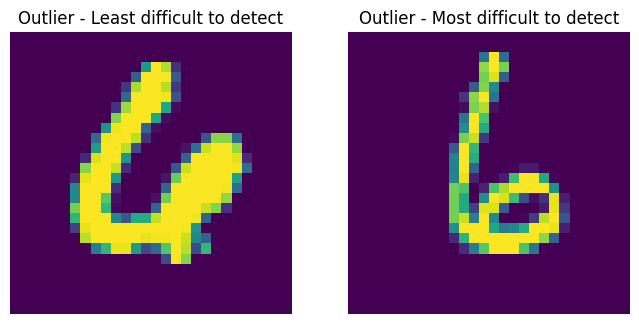

In [36]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_images_outlier_norm[np.argmax(ssim_outlier)])
plt.title("Outlier - Least difficult to detect")
plt.axis(False)
plt.subplot(122)
plt.imshow(test_images_outlier_norm[np.argmin(ssim_outlier)])
plt.title("Outlier - Most difficult to detect")
plt.axis(False)
plt.show()

## Convolutional Autoencoder - Second attempt


In [50]:
# Encoder
inp2 = tf.keras.layers.Input(shape=(train_images.shape[1], train_images.shape[2], 1))
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inp2)
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)  # 14x14
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)  # 7x7
x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)

# Decoder
y = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
y = tf.keras.layers.Conv2DTranspose(
    64, (3, 3), strides=2, padding="same", activation="relu"
)(y)
y = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(y)
y = tf.keras.layers.Conv2DTranspose(
    32, (3, 3), strides=2, padding="same", activation="relu"
)(y)
y = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(y)
out2 = tf.keras.layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(y)


conv_autoencoder2 = tf.keras.Model(inp2, out2)

conv_autoencoder2.compile(optimizer="rmsprop", loss="mse")

conv_autoencoder2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 14, 14, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 28, 28, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425,153 (1.62 MB)

 Trainable params: 425,153 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

### Training


In [51]:
start_time = time.time()

history = conv_autoencoder2.fit(
    train_images_regular_norm,
    train_images_regular_norm,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1335 - val_loss: 0.0353
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0280 - val_loss: 0.0222
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0201 - val_loss: 0.0204
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0151 - val_loss: 0.0171
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0134 - val_loss: 0.0163
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0084 - val_loss: 0.0126
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 10/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0076 - val_loss: 0.0093
Epoch 11/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 12/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

### Reconstruction Loss


In [52]:
reconstruction_loss_conv_outlier = conv_autoencoder2.predict(test_images_outlier_norm)
reconstruction_loss_conv_regular = conv_autoencoder2.predict(test_images_regular_norm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


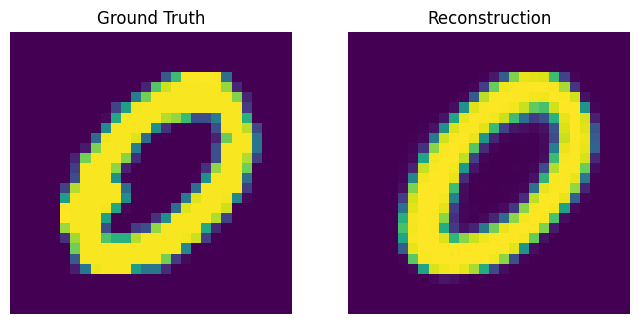

In [53]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_images_regular_norm[0])
plt.title("Ground Truth")
plt.axis(False)
plt.subplot(122)
plt.imshow(reconstruction_loss_dense_regular[0])
plt.title("Reconstruction")
plt.axis(False)
plt.show()

### SSIM - structural similarity index measure [Higher is better]


In [54]:
ssim_regular = calc_ssim(test_images_regular_norm, reconstruction_loss_dense_regular)
ssim_outlier = calc_ssim(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"SSIM Regular:\n {ssim_regular[:ssim_outlier.shape[0]]}")
print("Min:", ssim_regular.min())
print("Max:", ssim_regular.max())
print()
print(f"SSIM Outlier:\n {ssim_outlier}")
print("Min:", ssim_outlier.min())
print("Max:", ssim_outlier.max())

SSIM Regular:
 [0.9486784  0.920395   0.8679238  0.96758527 0.94441956 0.9552486
 0.93213505 0.9528528  0.9637776  0.94831085 0.87381196 0.88031286
 0.9553182  0.9654356  0.9042527  0.8766898  0.9438489  0.9313066
 0.9613122  0.903293   0.8980642  0.9590693  0.7716266  0.9371106
 0.8879989  0.67441106 0.9303652  0.96162176 0.96029943 0.9362689
 0.94440866 0.8972655  0.8933937  0.9055195  0.93996465 0.9671107
 0.9234559  0.9220115  0.9489624  0.94499284 0.9177298  0.73545736
 0.9276639  0.96325225 0.9420048  0.9368451  0.9216617  0.9430511
 0.87862813 0.9060234 ]
Min: 0.33272922
Max: 0.9767329

SSIM Outlier:
 [0.63664633 0.5832034  0.55494136 0.69699913 0.60458916 0.62553513
 0.62960184 0.51363647 0.67772037 0.69325453 0.7041239  0.42658126
 0.68658465 0.67722857 0.6642823  0.5966258  0.6646463  0.6209545
 0.4816837  0.45598683 0.7645092  0.64562917 0.50666255 0.6723342
 0.6161786  0.7076832  0.7029557  0.3871243  0.61052155 0.4944652
 0.49418306 0.53572696 0.58245254 0.47003618 0.58810

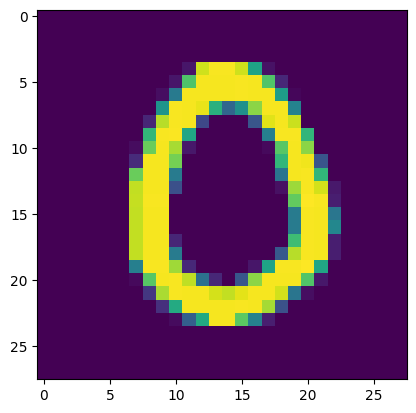

In [55]:
plt.imshow(test_images_regular_norm[np.argmax(ssim_regular)])
plt.show()

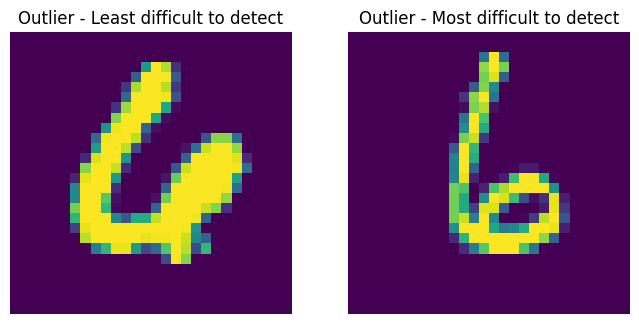

In [56]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_images_outlier_norm[np.argmax(ssim_outlier)])
plt.title("Outlier - Least difficult to detect")
plt.axis(False)
plt.subplot(122)
plt.imshow(test_images_outlier_norm[np.argmin(ssim_outlier)])
plt.title("Outlier - Most difficult to detect")
plt.axis(False)
plt.show()

Similar results as the smaller CNN.


## Conclusions

The autoencoders can effectively serve as anomaly detectors. Both the MLP and CNN models showed higher reconstruction loss (mse) for the outlier images compared to regular digits.The SSIM metric further validates this approach, showing worse structural similarity for outlier reconstructions.
